## Imports

In [2]:
import pathlib

from astropy.io import fits
import astropy.coordinates as coord
import astropy.table as at
from astropy.time import Time
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from scipy.optimize import minimize
from scipy.signal import argrelmax

In [4]:
apid = '2M04123153+6738486'

In [5]:
data_path = pathlib.Path('~/data/APOGEE_DR17').expanduser().resolve()

In [6]:
allstar = at.Table.read(data_path / 'allStarLite-dr17-synspec_rev1.fits')

In [7]:
allvisit = at.Table.read(data_path / 'allVisitLite-dr17-synspec.fits')

In [8]:
star = allstar[allstar['APOGEE_ID'] == apid]
c = coord.SkyCoord(ra=star['RA']*u.deg, dec=star['DEC']*u.deg)[0]
star['LOGG', 'TEFF', 'FE_H', 'ALPHA_M']

LOGG,TEFF,FE_H,ALPHA_M
float32,float32,float32,float32
1.9763849,4214.5107,-0.81562,6.100163e-05


In [9]:
star['ASPCAPFLAGS']

"VMICRO_WARN,STAR_WARN,COLORTE_WARN"


In [10]:
diagnostic_url = (
    "https://data.sdss.org/sas/apogeework/apogee/spectro/redux/dr17/stars/"
    + f"{star['TELESCOPE'][0]}/{star['FIELD'][0]}"
)
print(diagnostic_url)

https://data.sdss.org/sas/apogeework/apogee/spectro/redux/dr17/stars/apo25m/140+12


In [11]:
visits = allvisit[allvisit['APOGEE_ID'] == '2M04123153+6738486']
visits.sort('JD')
visits['JD', 'VHELIO']

JD,VHELIO
float64,float64
2457279.99438,-86.96878061638574
2457292.96813,-59.995043083621184
2457320.92338,-7.598405828513279
2457323.87005,-10.865378668762826


In [12]:
import pathlib
from urllib.request import urlopen
import requests
from tqdm import tqdm


def download_file(
    url, 
    local_path=None, 
    local_filename=None, 
    block_size=4096,
    overwrite=False
):
    if local_path is None:
        local_path = '.'
    local_path = pathlib.Path(local_path).resolve().absolute()
    
    if local_filename is None:
        local_filename = url.split('/')[(-1)]
    full_local_path = local_path / local_filename
    
    if full_local_path.exists() and not overwrite:
        return full_local_path
    
    site = urlopen(url)
    meta = site.info()
    total_size = int(meta['Content-Length'])
    
    response = requests.get(url, stream=True)
    progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True)
    with open(full_local_path, 'wb') as f:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            f.write(data)

    progress_bar.close()
    return full_local_path

In [13]:
apstar_url = (
    "https://data.sdss.org/sas/dr17/apogee/spectro/redux/dr17/stars/"
    + f"{star['TELESCOPE'][0]}/{star['FIELD'][0]}/"
    + f"apStar-dr17-{star['APOGEE_ID'][0]}.fits"
)

local_cache_path = pathlib.Path('../data')
local_cache_path.mkdir(exist_ok=True)

apstar_filename = download_file(apstar_url, local_path=local_cache_path)

In [14]:
hdulist = fits.open(apstar_filename)
hdulist.info()

Filename: /mnt/ceph/users/apricewhelan/projects/safari/data/apStar-dr17-2M04123153+6738486.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     132   ()      
  1                1 ImageHDU        12   (8575, 6)   float64   
  2                1 ImageHDU        12   (8575, 6)   float64   
  3                1 ImageHDU        12   (8575, 6)   int64   
  4                1 ImageHDU        12   (8575, 6)   float64   
  5                1 ImageHDU        12   (8575, 6)   float64   
  6                1 ImageHDU        12   (8575, 6)   float64   
  7                1 ImageHDU        12   (8575, 6)   float64   
  8                1 ImageHDU         5   ()      
  9                1 BinTableHDU     58   4R x 23C   [72A, D, D, D, D, D, D, D, D, D, D, D, D, D, 765D, 765D, 765D, D, D, D, D, D, 765D]   
 10                1 BinTableHDU     58   1R x 23C   [72A, D, D, D, D, D, D, D, D, D, D, D, D, D, 243D, 243D, 243D, D, D, D, D, D, 243D]   


In [15]:
tbl = at.Table(hdulist[9].data)

Text(0.5, 0, '$\\Delta v$')

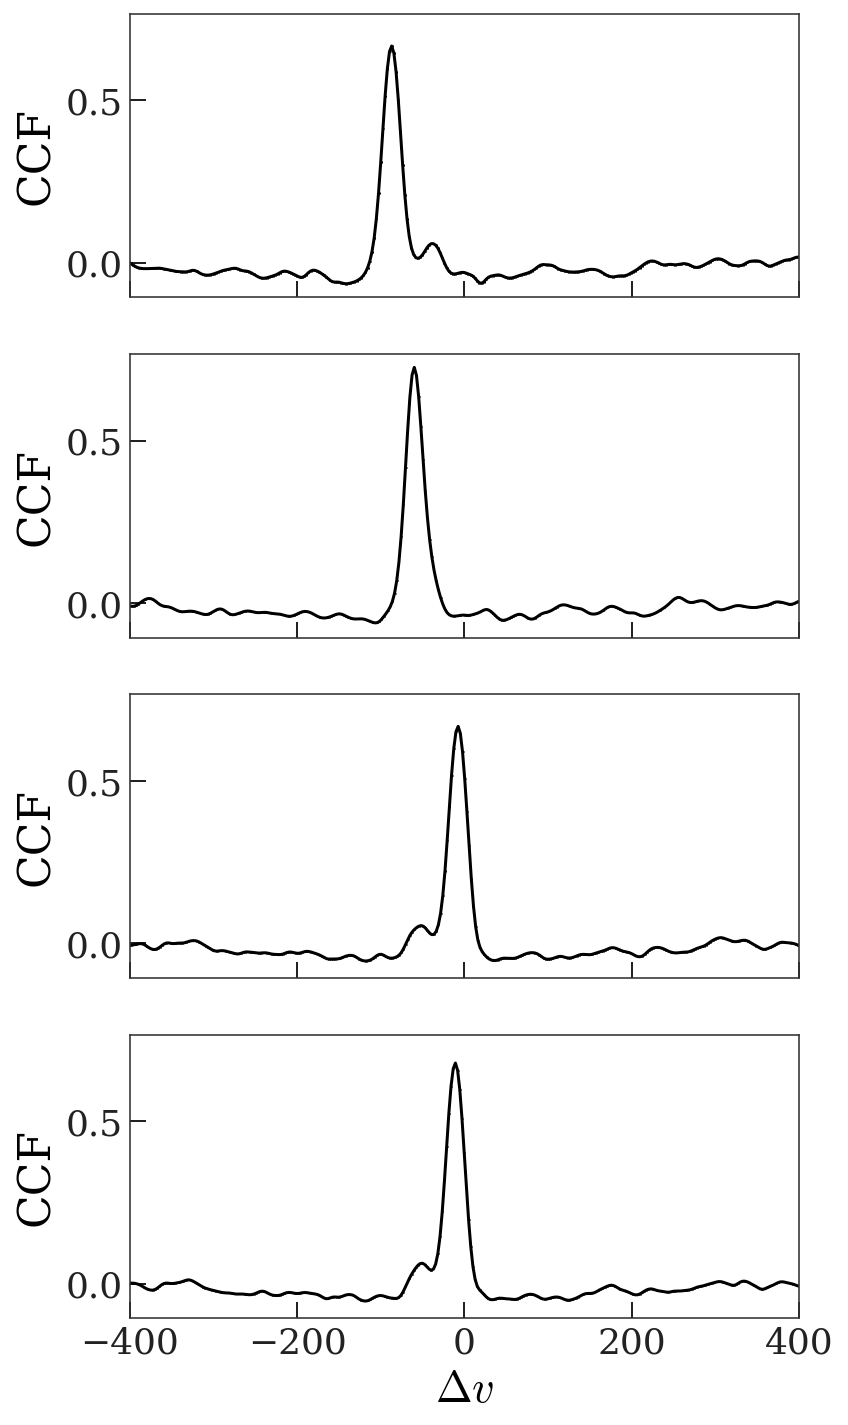

In [16]:
fig, axes = plt.subplots(
    len(tbl), 1, 
    figsize=(6, 3 * len(tbl)), 
    sharex=True, 
    sharey=True
)

for ax, row in zip(axes, tbl):
    ax.errorbar(row['x_ccf'], row['ccf'], row['ccferr'], marker='')
    ax.set_ylabel('CCF')
    
ax.set_xlim(-400, 400)
ax.set_xlabel(r'$\Delta v$')

## Some Baroque-ass fits to the CCFs:

To measure the RVs of the two peaks in the CCF. Apparently the velocities here have been Barycenter-corrected.

In [17]:
def gaussian(p, x):
    A, x0, sigma = p
    return A / (np.sqrt(2*np.pi) * sigma) * np.exp(-0.5 * (x - x0)**2 / sigma**2)

def model(p, x):
    model_y1 = gaussian(p[:3], x)
    model_y2 = gaussian(p[3:6], x)
    model_y3 = np.poly1d(p[6:])(x)
    model_y = model_y1 + model_y2 + model_y3
    return model_y

def chisq(p, x, y, yerr):
    model_y = model(p, x)
    return np.sum((y - model_y)**2 / yerr**2)

def ln_likelihood(p, x, y, yerr):
    return -0.5 * chisq

In [18]:
def get_data(row):
    x, y, yerr = row['x_ccf'], row['ccf'], row['ccferr']
    mask = (x > -400) & (x < 400)
    return x[mask], y[mask], yerr[mask]

In [19]:
fitted_pars = []
init_pars = []
for row in tbl:
    x, y, yerr = get_data(row)

    init = (0.5, x[y.argmax()], 10.,
            0.05, x[y.argmax()] + 20, 10.,
            4e-7, 0, -0.05)
    res = minimize(chisq, x0=init, args=(x, y, yerr), method='powell')
    print(res)
    fitted_pars.append(res.x)
    init_pars.append(init)

   direc: array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-7.97669467e-02, -2.82749981e-02, -5.39193685e-02,
         1.47223251e-01, -1.68821903e-01,  4.48496385e-01,
        -5.44786773e-09,  2.13960473e-09,  5.20183545e-04],
       [ 7.69100127e-01, -3.19464387e-03,  3.29349398e-02,
         4.55349847e-02,  1.15472717e+00, -1.21407548e-01,
        -1.94983252e-09,  1.60987307e-06,  3.35967788e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,

-87.10814085207817 -39.59659237452311
-59.979060976974615 -36.86089247408638
-7.808734656787118 -52.292236883268835
-11.05857123908802 -51.89297404288302


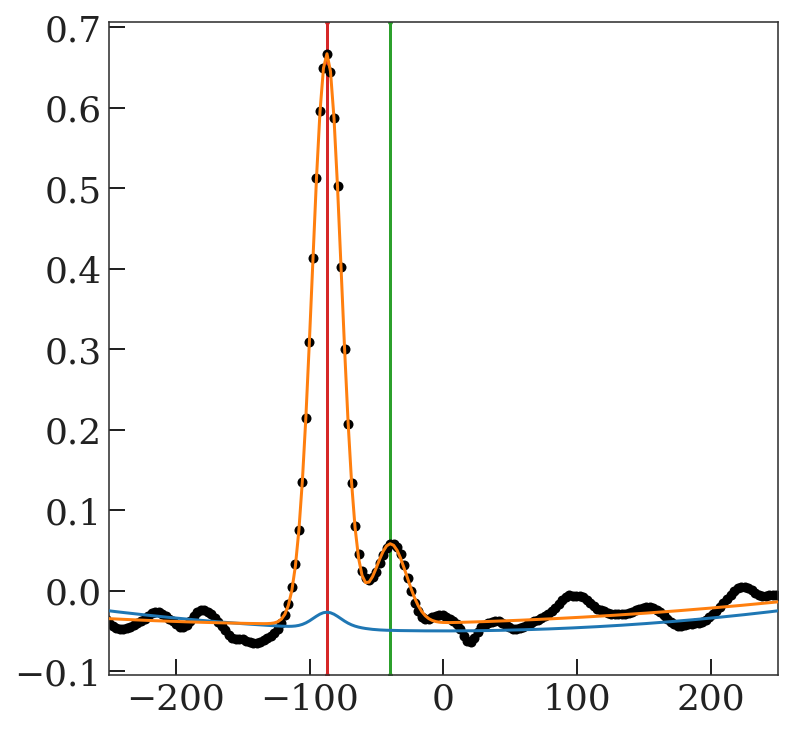

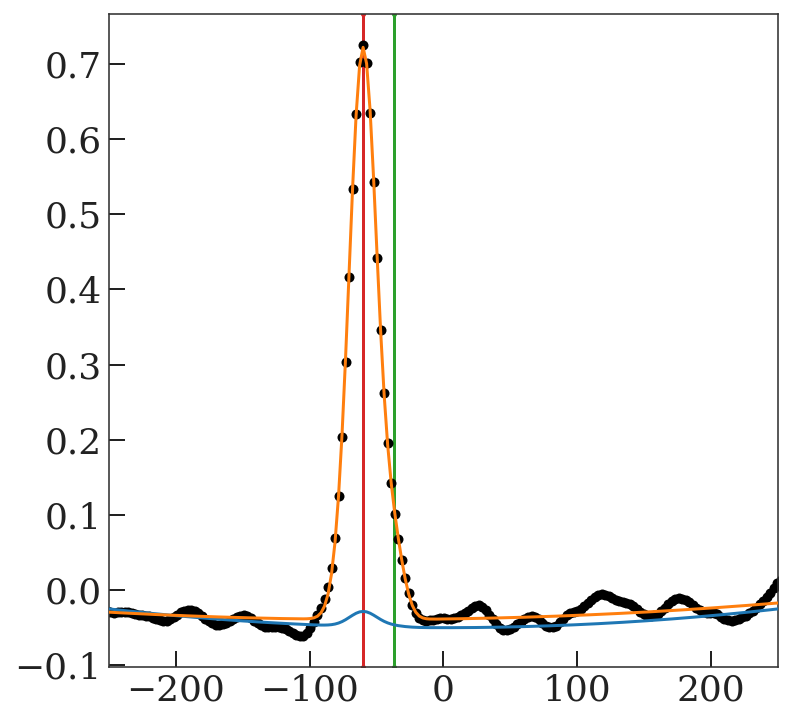

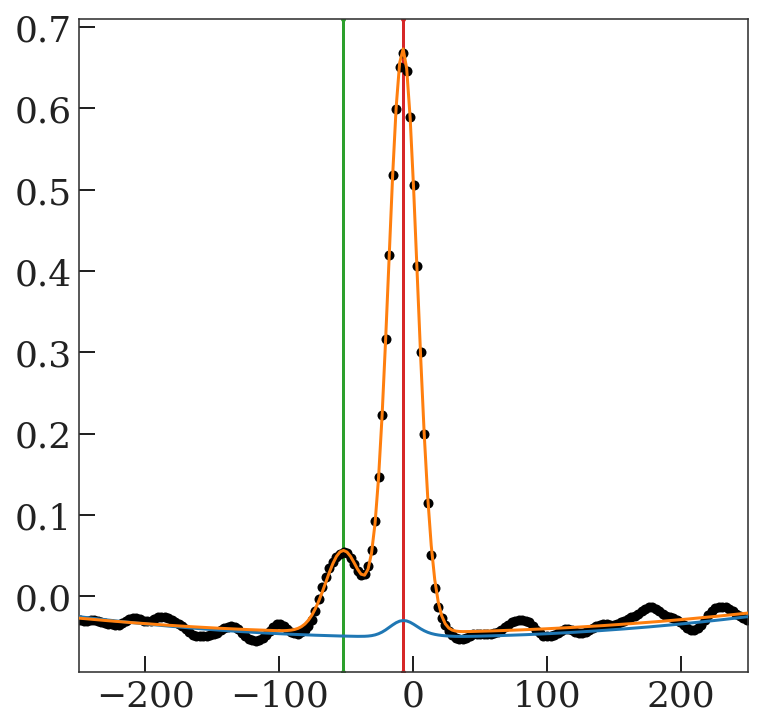

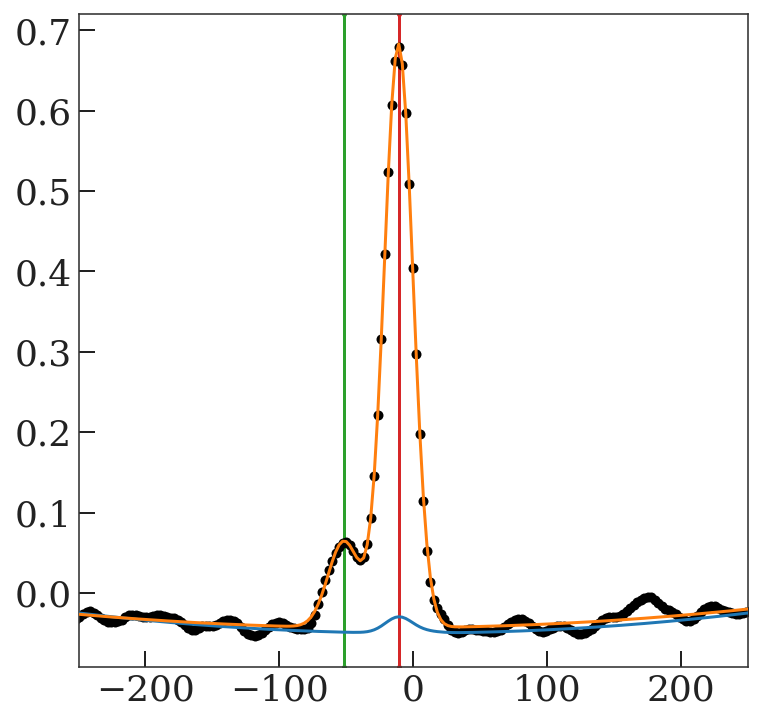

In [20]:
rv1s = []
rv2s = []
for row, fitp, init in zip(tbl, fitted_pars, init_pars):
    x, y, yerr = get_data(row)
    t = Time(row['jd'], format='jd', scale='tcb')
    apo = coord.EarthLocation.of_site('APO')
    BC = c.radial_velocity_correction(obstime=t, location=apo).to('km/s')  
    
    i1 = np.argmax([fitp[0], fitp[3]])
    i2 = np.argmin([fitp[0], fitp[3]])
    rv1 = fitp[[1, 4][i1]]
    rv2 = fitp[[1, 4][i2]]
    rv1s.append(rv1)
    rv2s.append(rv2)
    print(rv1, rv2)
    
    plt.figure()
    plt.errorbar(x, y, yerr, marker='o', ls='none')
    plt.plot(x, model(init, x), zorder=10, marker='')
    plt.plot(x, model(fitp, x), zorder=100, marker='')
    plt.xlim(-250, 250)
    plt.axvline(rv1, color='tab:red')
    plt.axvline(rv2, color='tab:green')

### Experiment with truly overkill fitting:

In [218]:
import celerite2
from celerite2 import terms
import pymc3_ext as pmx

In [257]:
def ln_normal(x, mu, sigma):
    return -0.5 * (np.log(2*np.pi * sigma**2) + (x - mu)**2 / sigma**2)

def two_peak_model(p1, p2, x):
    model_y1 = gaussian(p1, x)
    model_y2 = gaussian(p2, x)
    model_y = model_y1 + model_y2
    return model_y

def set_params(params, x, y, yerr, gp):
    gp.mean = params[0]
    theta = np.exp(params[1:3])
    gp.kernel = terms.Matern32Term(sigma=theta[0], rho=theta[1])    
    gp.compute(x, yerr=yerr, quiet=True)
    return gp

def ln_likelihood(p, x, y, yerr, gp):
    yy = y - two_peak_model(p[3:6], p[6:], x)
    gp = set_params(p, x, yy, yerr, gp)
    return gp.log_likelihood(yy)

def get_data(row):
    return row['x_ccf'], row['ccf'], row['ccferr']

In [281]:
def plot_prediction(raw_data, x, y, yerr, gp):    
    plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0, label="truth")

    mu, variance = gp.predict(y, t=raw_data[0], return_var=True)
    sigma = np.sqrt(variance)
    plt.plot(raw_data[0], mu, label="prediction", color='tab:blue')
    plt.fill_between(raw_data[0], mu - sigma, mu + sigma, color="tab:blue", alpha=0.2)
    
    
def plot_full_prediction(x, y, yerr, gp, fitp):    
    plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0, label="truth")
    
    gauss_model = two_peak_model(fitp[3:6], fitp[6:], raw_data[0])
    mu, variance = gp.predict(y - gauss_model, t=x, return_var=True)
    sigma = np.sqrt(variance)
    mu = mu + gauss_model
    plt.plot(x, mu, label="prediction", color='tab:blue')
    plt.fill_between(x, mu - sigma, mu + sigma, color="tab:blue", alpha=0.2)

Initial log likelihood: 2672.280514845229
[-0.0089768  -3.7980083   3.63499038]
[-9.58474219e-03 -3.81016902e+00  3.61528301e+00  1.84481869e+01
 -8.71754760e+01  1.06942844e+01  2.20992304e+00 -3.73499720e+01
  1.02507653e+01] [-6.07942113e-04 -1.21607156e-02 -1.97073744e-02 -1.03605193e+00
 -6.74351109e-02 -2.73736401e-01 -7.70080790e-01  2.24652040e+00
 -1.70065405e+00]
Initial log likelihood: 2786.7925784641916
[-0.00911184 -3.58893469  3.89308741]
[-8.95784009e-03 -3.60405607e+00  3.87534392e+00  1.78646534e+01
 -6.03248899e+01  9.83195702e+00  2.53904992e+00 -4.02422119e+01
  9.72011877e+00] [ 1.54003604e-04 -1.51213815e-02 -1.77434942e-02 -2.11057162e+00
 -3.45928961e-01 -6.52273814e-01  9.72730386e-01 -3.38141943e+00
  2.06203572e+00]
Initial log likelihood: 2734.0723218615885
[-0.01016847 -3.74788633  3.65999494]
[-1.15800295e-02 -3.73931945e+00  3.64648918e+00  1.97975053e+01
 -7.61305970e+00  1.09876219e+01  3.21746937e+00 -5.37273787e+01
  1.34038126e+01] [-1.41156356e-03  

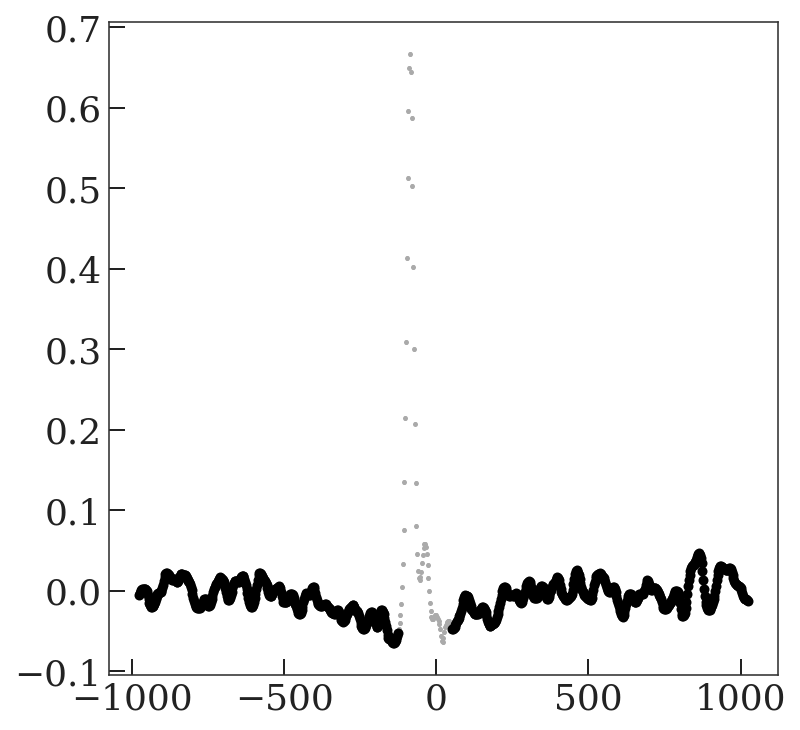

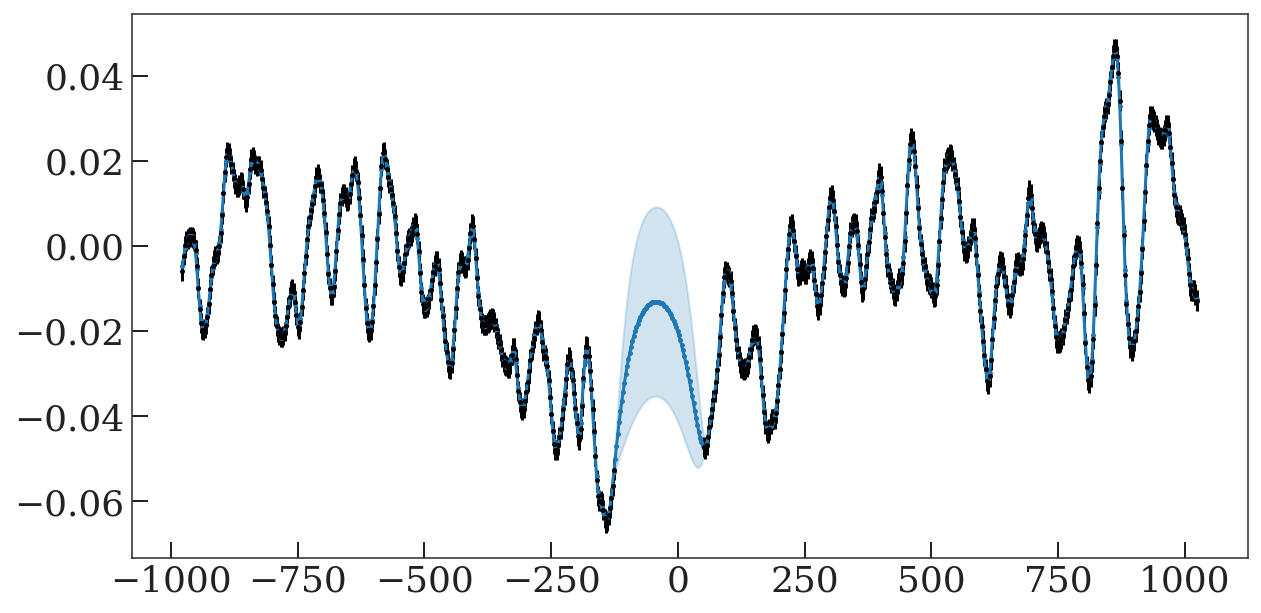

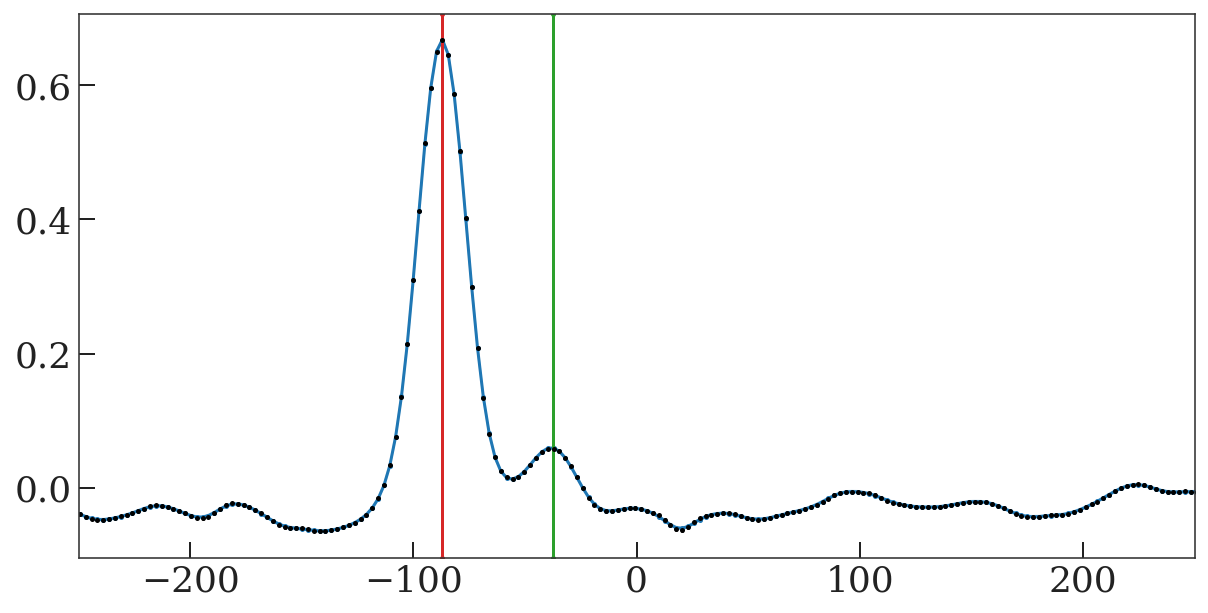

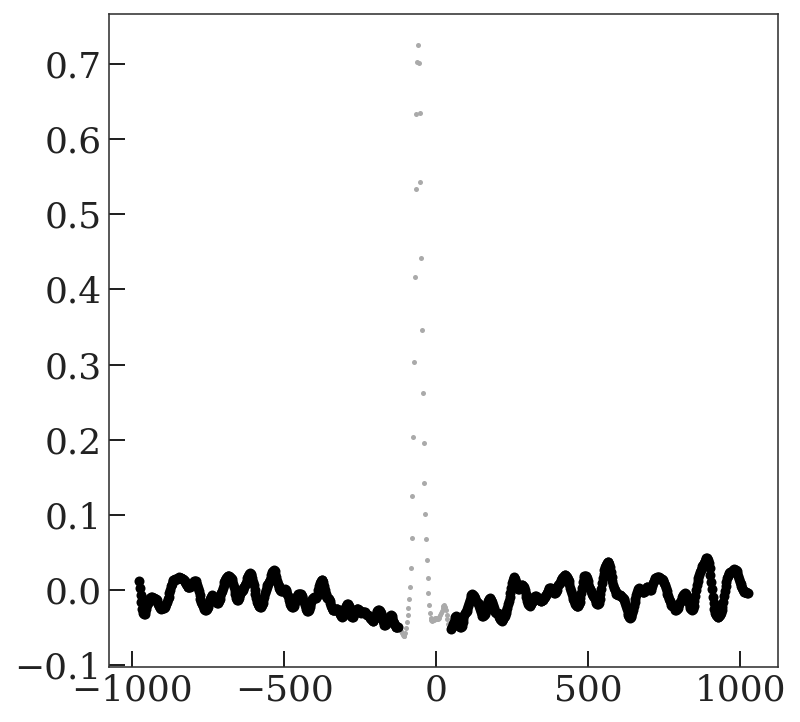

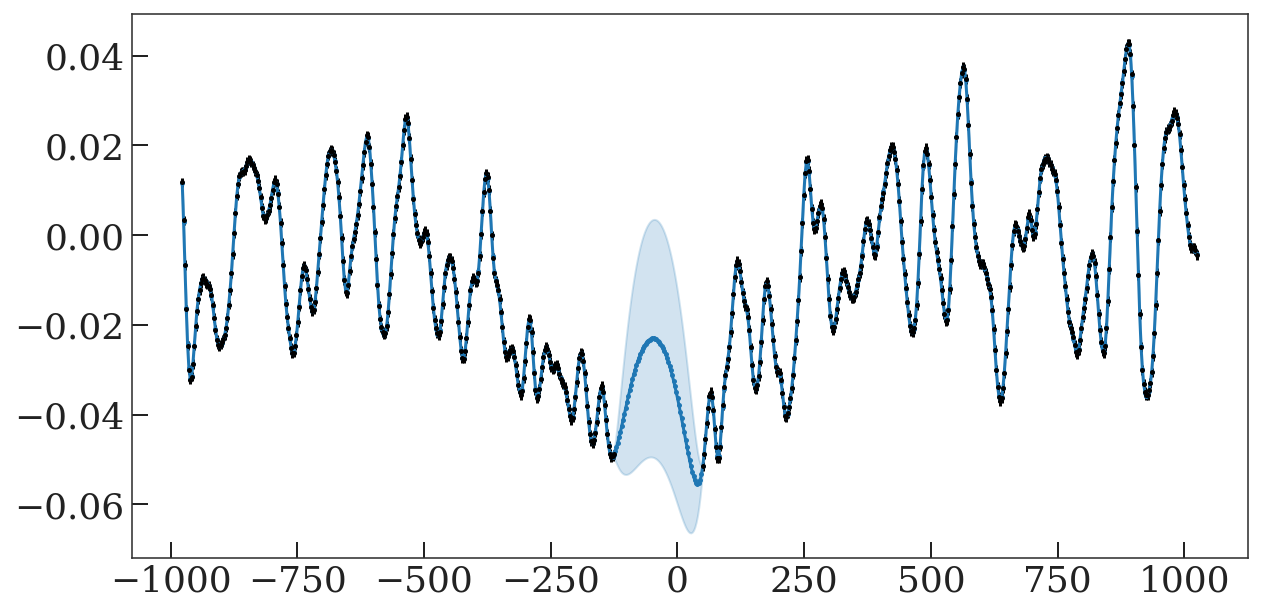

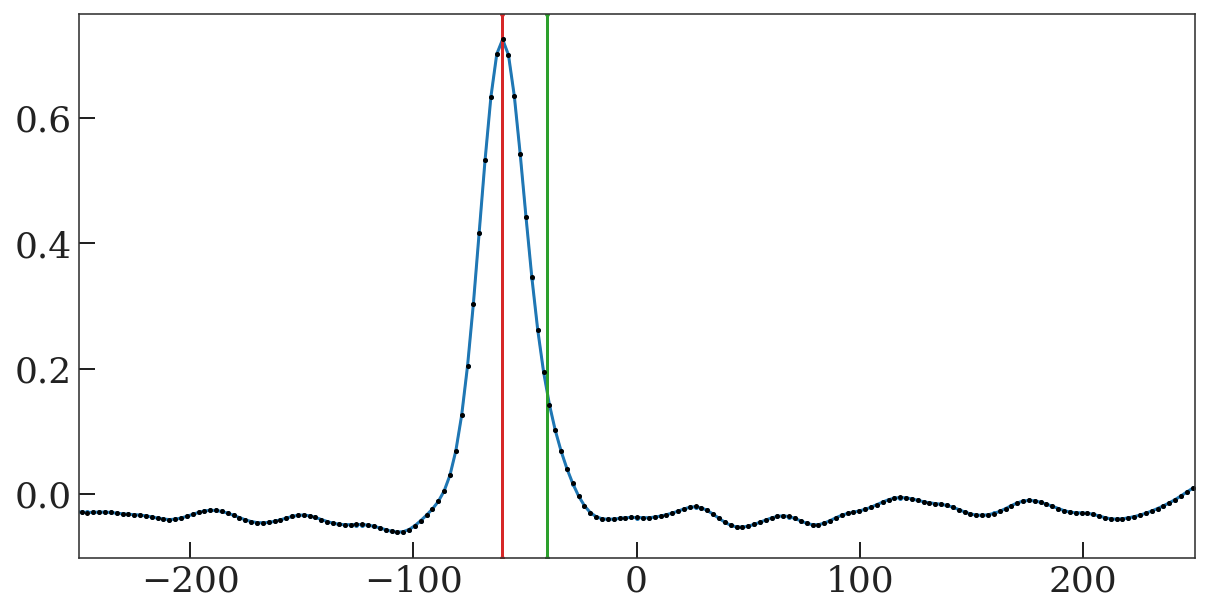

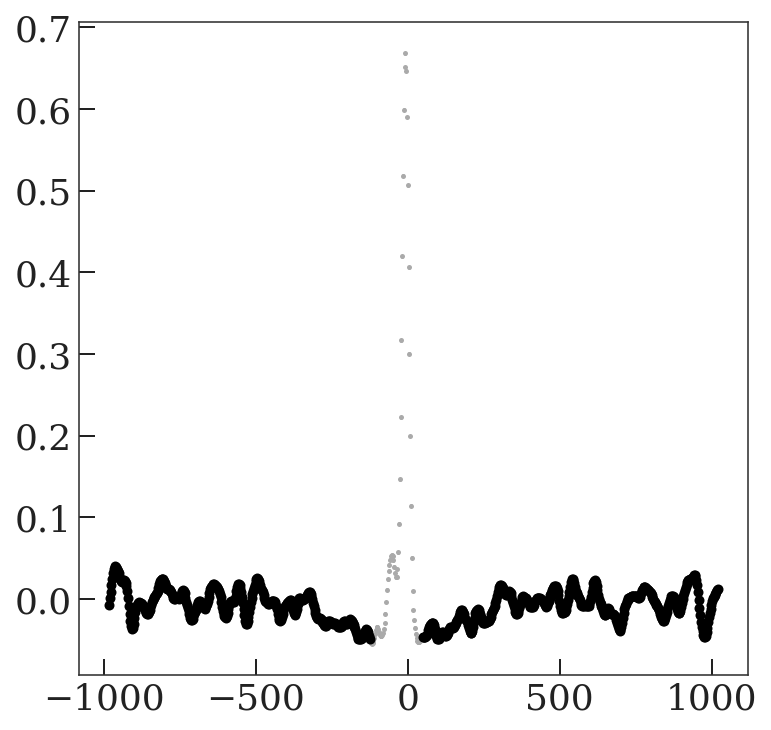

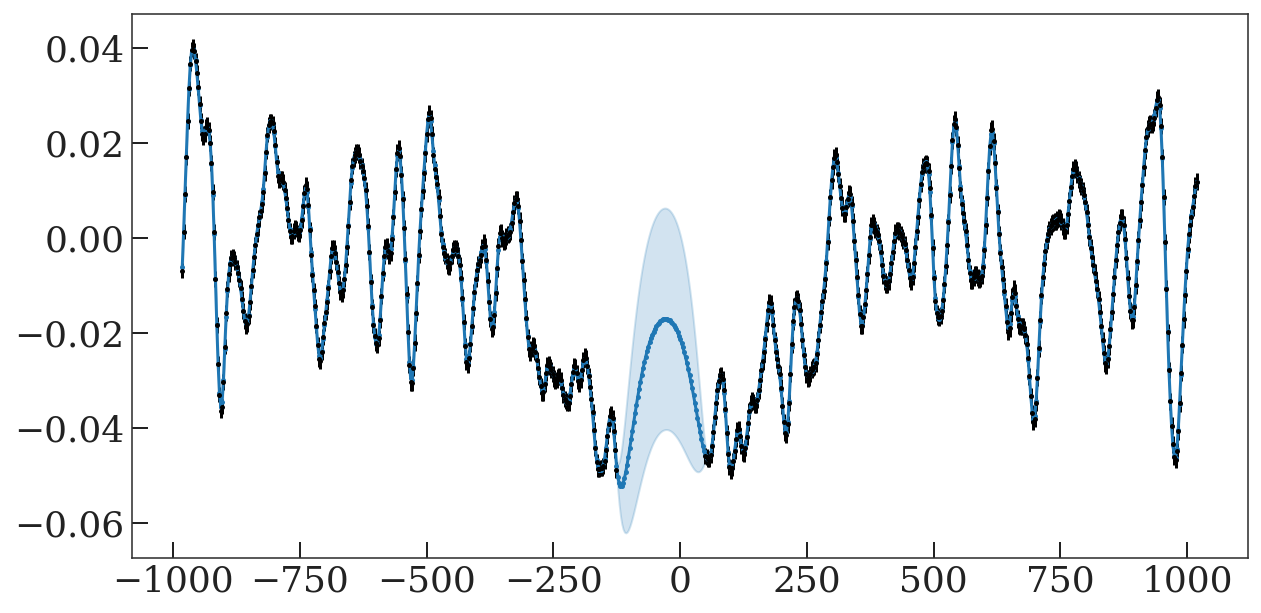

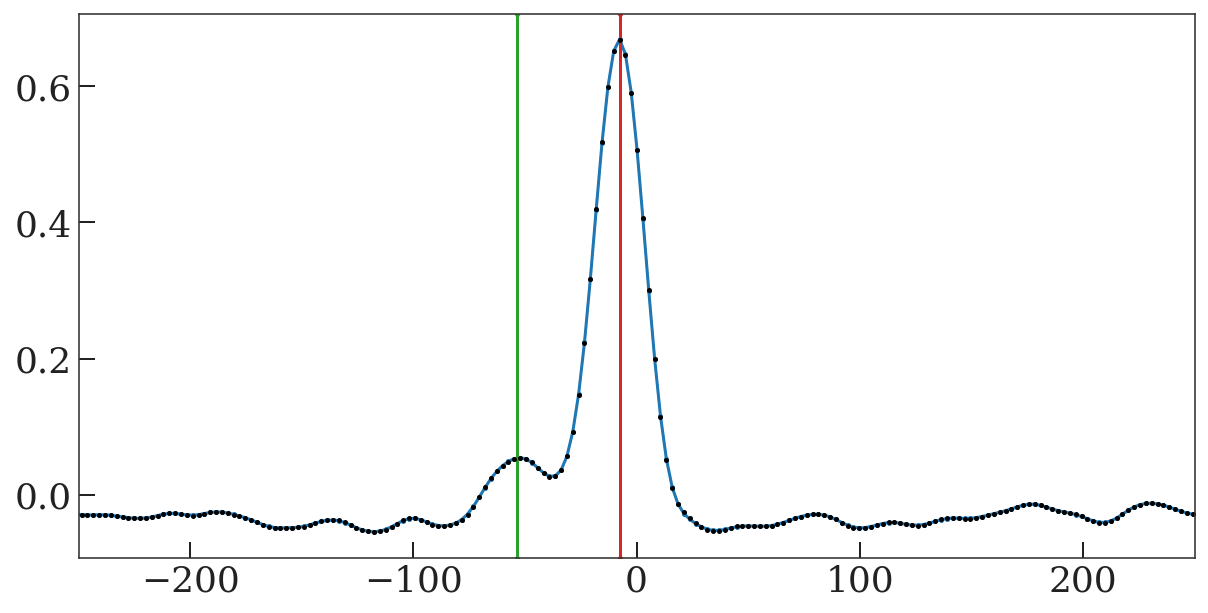

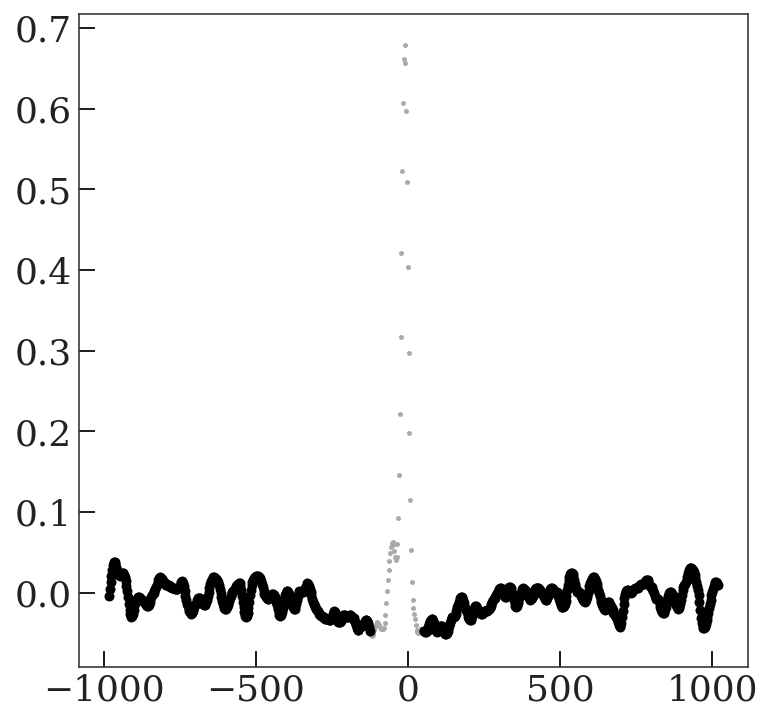

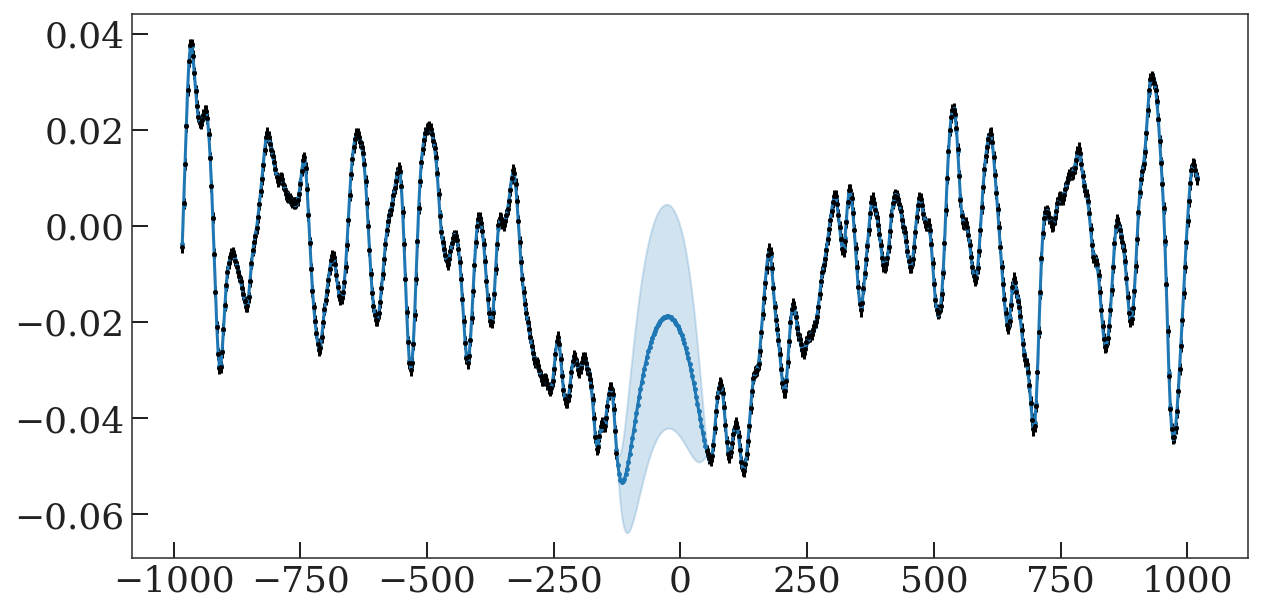

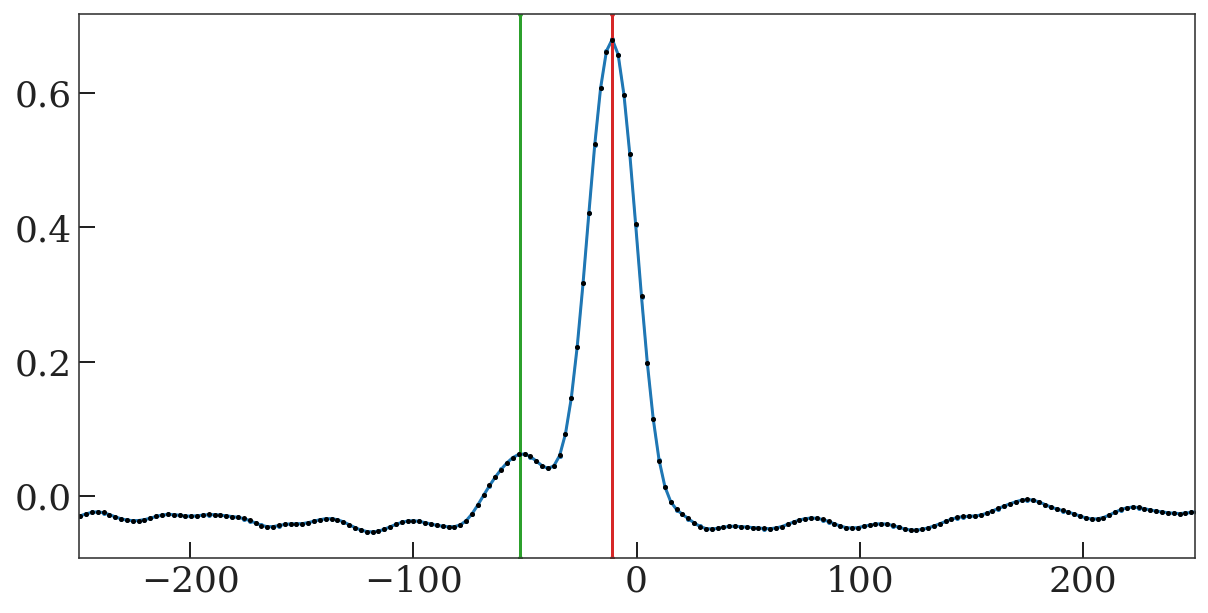

In [285]:
gp_fitted_pars = []
gp_rv1s = []
gp_rv2s = []
for row, fitp, init in zip(tbl, fitted_pars, init_pars):
    raw_data = get_data(row)
    
    mask = (raw_data[0] < -125) | (raw_data[0] > 50)
    
    x, y, yerr = raw_data
    x = x[mask]
    y = y[mask]
    yerr = yerr[mask]
    
    plt.figure()
    plt.errorbar(*raw_data, marker='.', ls='none', color='#aaaaaa')
    plt.errorbar(x, y, yerr, marker='o', ls='none', color='k')
    
    # ------------
    # Setup the GP
    kernel = terms.Matern32Term(sigma=np.exp(-3.0), rho=np.exp(3.0))
    gp = celerite2.GaussianProcess(kernel, mean=0.)
    gp.compute(x, yerr=yerr)
    print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))
    
    # First only fit the GP params, away from peak:
    initial_params = [0., -3, 3]
    null_gauss_p = [0., 1, 1, 0, 1, 1]

    def neg_ll(p, x, y, yerr, gp):
        pp = np.concatenate((p, null_gauss_p))
        return -ln_likelihood(pp, x, y, yerr, gp)

    args = (x, y, yerr, gp)
    gp_soln = minimize(neg_ll, initial_params, method="L-BFGS-B", args=args)
    print(gp_soln.x)
    opt_gp = set_params(gp_soln.x, *args)
    
    plt.figure(figsize=(10, 5))
    plot_prediction(raw_data, x, y, yerr, gp)
    
    # Now fit the full model:
    def neg_ll(p, x, y, yerr, gp):
        return -ln_likelihood(p, x, y, yerr, gp)

    args = (raw_data[0], raw_data[1], raw_data[2], gp)
    init = np.concatenate((gp_soln.x, fitp[:6] + 1e-4))
    soln = minimize(neg_ll, init, method="L-BFGS-B", args=args)
    print(soln.x, soln.x - init)
    opt_gp = set_params(soln.x, *args)
    
    rv1 = soln.x[4]
    rv2 = soln.x[4 + 3]
    
    plt.figure(figsize=(10, 5))
    plot_full_prediction(*raw_data, gp, soln.x)
    plt.xlim(-250, 250)
    plt.axvline(rv1, color='tab:red')
    plt.axvline(rv2, color='tab:green')
    
    gp_fitted_pars.append(soln.x)
    gp_rv1s.append(rv1)
    gp_rv2s.append(rv2)

## Load the HIRES and PEPSI RV data:

In [21]:
jaya_data = at.Table.read("""
BJD rv rv_err
2459441.12722 -26.94 0.10
2459442.11471 -30.43 0.10
2459457.11748 -74.32 0.10
2459467.98696 -87.423 0.060
2459472.12548 -86.11 0.10
2459485.12694 -57.29 0.10
2459489.96760 -41.928 0.034
2459502.97527 -9.84 0.10
2459511.98487 -7.61 0.10
2459537.92734 -73.81 0.10""", format='ascii.basic')

---

## Combine APOGEE and HIRES/PEPSI data, fit with The Joker

In [22]:
import thejoker as tj
import pymc3 as pm

In [286]:
datas = {
    '1': tj.RVData(
        t=Time(np.concatenate((visits['JD'], jaya_data['BJD'])), 
               format='jd', scale='tcb'),
        rv=np.concatenate((gp_rv1s, jaya_data['rv'])) * u.km/u.s,
        rv_err=np.concatenate((np.full_like(gp_rv1s, 1.), jaya_data['rv_err'])) * u.km/u.s
    ),
    '2': tj.RVData(
        t=Time(visits['JD'], format='jd', scale='tcb'),
        rv=gp_rv2s * u.km/u.s,
        rv_err=np.full_like(gp_rv2s, 1.) * u.km/u.s
    )
}

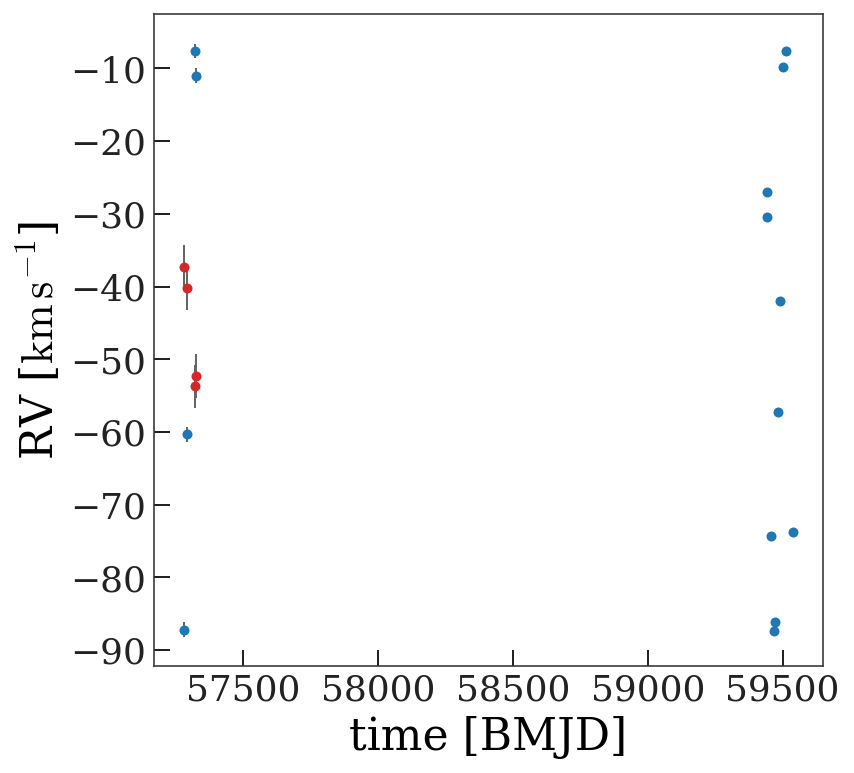

In [288]:
for data, color in zip(datas.values(), ['C1', 'C4']):
    _ = data.plot(color=color)

In [295]:
from thejoker.prior import default_nonlinear_prior
from thejoker.prior_sb2 import default_linear_prior_sb2
import exoplanet.units as xu

In [314]:
with pm.Model() as model:
    v = xu.with_unit(pm.Normal('v0', -45, 25), u.km/u.s)
    P = xu.with_unit(pm.Normal('P', 81, 0.5), u.day)
    e = xu.with_unit(pm.Uniform('e', 0, 0.01), u.one)
    pars = {}
    pars.update(default_nonlinear_prior(pars={'P': P, 'e':e}))
    pars.update(default_linear_prior_sb2(
        sigma_K0_1=30*u.km/u.s,
        P0_1=1*u.day,
        sigma_K0_2=30*u.km/u.s,
        P0_2=1*u.day,
        pars={'v0': v}
    ))
    
with model:
    prior = tj.JokerSB2Prior(pars)

In [315]:
# with pm.Model() as model:
#     prior = tj.JokerSB2Prior.default(
#         P_min=80*u.day, P_max=82*u.day,
#         sigma_v=100*u.km/u.s,
#         sigma_K0_1=30*u.km/u.s,
#         sigma_K0_2=30*u.km/u.s)

In [316]:
joker = tj.TheJokerSB2(prior)

In [323]:
prior_samples, _ = prior.sample(size=10_000_000)

In [324]:
samples = joker.rejection_sample(
    datas, 
    prior_samples, 
    max_posterior_samples=256
)
len(samples)

(0.0, 0.1)

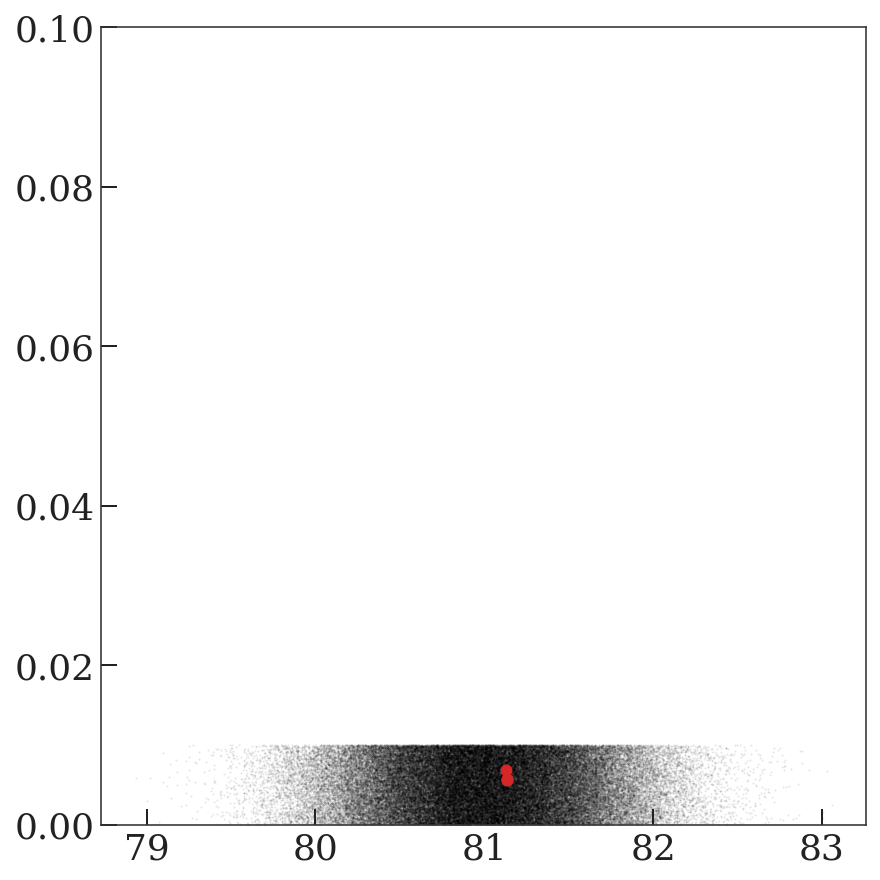

In [328]:
fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)
ax.scatter(samples['P'], samples['e'], color='tab:red')
ax.plot(prior_samples['P'][::100], prior_samples['e'][::100], 
        ls='none', marker='o', mew=0, ms=1, alpha=0.1,
        zorder=-1)
ax.set_ylim(0, 0.1)

(-100.0, 5.0)

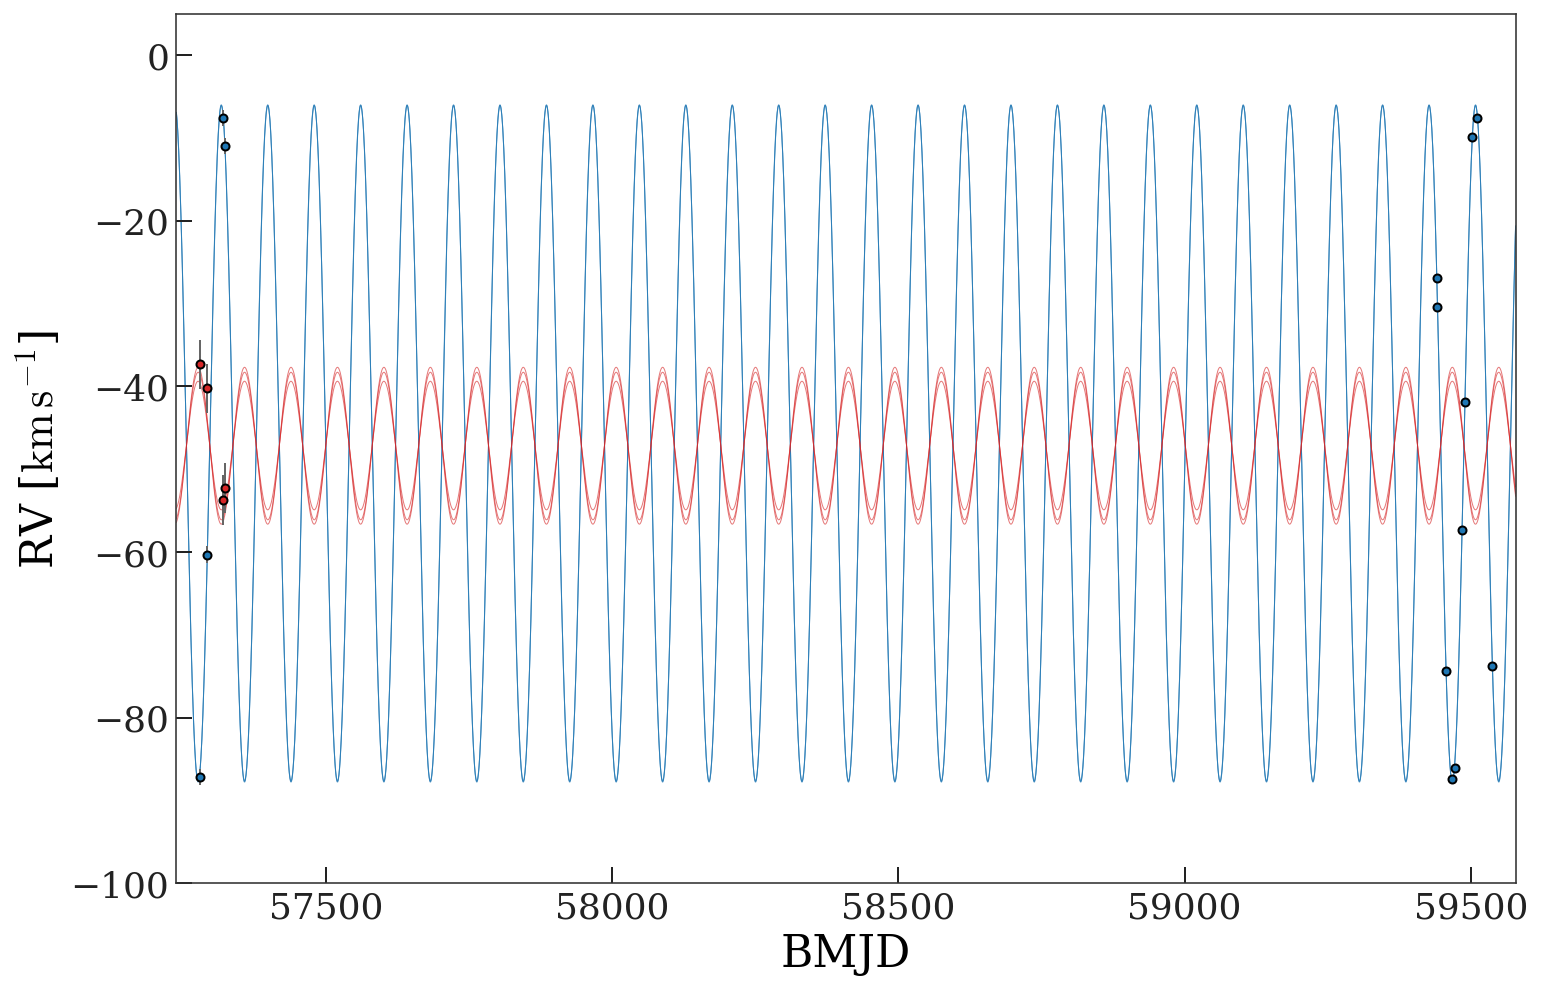

In [329]:
PP = np.median(samples['P']).value
ptp = datas['1'].t.max() - datas['1'].t.min()
tgrid = datas['1'].t.min() + np.linspace(-0.5 * PP, ptp.jd + 0.5 * PP, 4096) * u.day

fig, ax = plt.subplots(figsize=(12, 8))
_ = tj.plot_rv_curves(data=datas['1'], samples=samples.primary,
                      data_plot_kwargs=dict(color='tab:blue', zorder=100, mew=1, mec='k'),
                      plot_kwargs=dict(color='tab:blue', zorder=-100),
                      t_grid=tgrid, ax=ax)
# ax.set_xlim(t0.mjd, t0.mjd + 5*truth1['P'].value)
# ax.set_ylim(-75, 75)

_ = tj.plot_rv_curves(data=datas['2'], samples=samples.secondary, 
                      data_plot_kwargs=dict(color='tab:red', zorder=100, mew=1, mec='k'),
                      plot_kwargs=dict(color='tab:red', zorder=-100),
                      t_grid=tgrid, ax=ax)

# ax.set_xlim(t0.mjd, t0.mjd + 5*truth1['P'].value)
ax.set_ylim(-100, 5)

In [337]:
at.Table({'rv1': gp_rv1s, 'rv2': gp_rv2s}).pprint()

       rv1                 rv2        
------------------ -------------------
-87.17547596297862  -37.34997197612718
 -60.3248899378247  -40.24221190267273
-7.613059700516017  -53.72737867608866
-10.99530331426474 -52.300568343535254


In [330]:
K1 = np.abs(samples.primary['K'])
K2 = np.abs(samples.secondary['K'])
q = K2 / K1

In [333]:
np.mean(q), np.std(q)

(<Quantity 0.21342455>, <Quantity 0.01734739>)

Text(0.5, 0, '$q$')

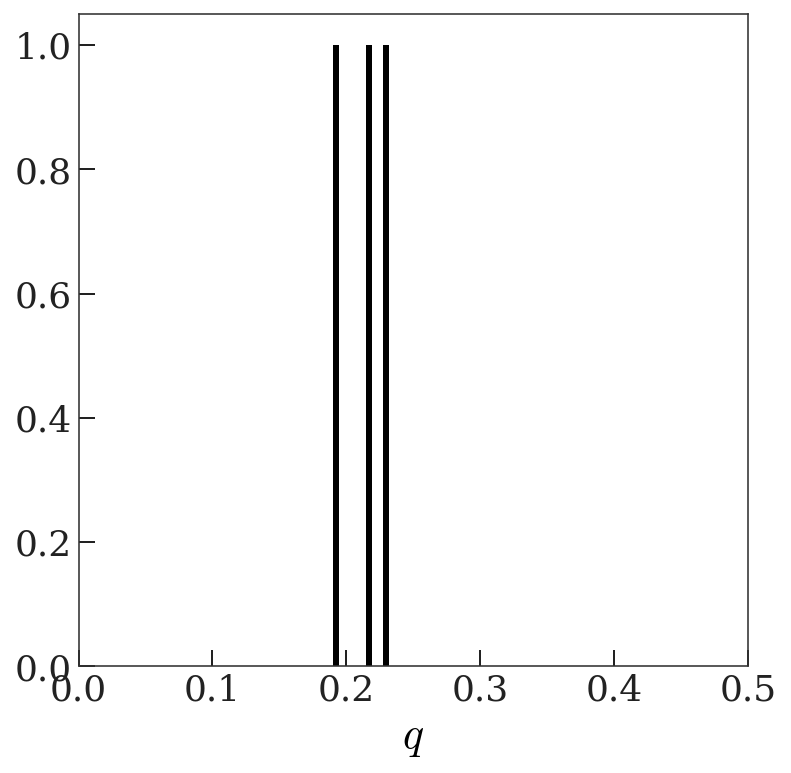

In [331]:
plt.hist(q.value)
plt.xlim(0, 0.5)
plt.xlabel('$q$')